# Session 2: Solving Real Lab Problems with Python + AI

## Learning Goals

By the end of this session, you will be able to:

1. **See your problem as a data problem** - What data do I have? What do I want to extract from it?
2. **Formulate the problem clearly** - Describe it with enough detail that someone (or an AI) could solve it
3. **Vibe code a solution and review it** - Get working code and understand what it does
4. **Visualize to verify** - Use plots to check if results make sense
5. **Think critically about correctness** - How would I know if this is wrong?
6. **Not be afraid to try** - Experiment, iterate, learn from failures

## Our Approach: Vibe Coding

Today we won't focus on *writing* code - we'll focus on **thinking about problems**.

For each problem we'll:
- Look at the **real scenario** and the data
- **Discuss as a group** - what's the question? what do we need?
- **Write a vibe prompt** - how would you ask an AI to help?
- **Run the solution** and interpret the output
- **Ask: how do we know this is correct?**

---

In [1]:
# Run this cell first - loads all the tools we'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit

from workshop_utils import snip_baseline, logistic_fn, logistic_growth, COLOR_MAP
from session2_utils import (
    load_fsec_data, load_dose_response_data, load_plate_reader_data,
    load_spectro_data, preview_marco_samples, 
    generate_procrustes_example, plot_procrustes_context
)

plt.rcParams['figure.dpi'] = 100
print("Ready to go!")

Ready to go!


---

# Problem 1: "When Should We Induce Protein Expression?"

## The Scenario

You're growing *E. coli* cultures for recombinant protein expression. You have a plate reader monitoring three different expression constructs overnight.

**The critical question:** When do we add IPTG to induce expression?

- **Too early** (lag phase): Cells are stressed, low yield
- **Just right** (mid-log phase): Cells are healthy and dividing fast, maximum yield!
- **Too late** (stationary phase): Nutrients depleted, cells dying, poor yield

Here's what your plate reader shows:

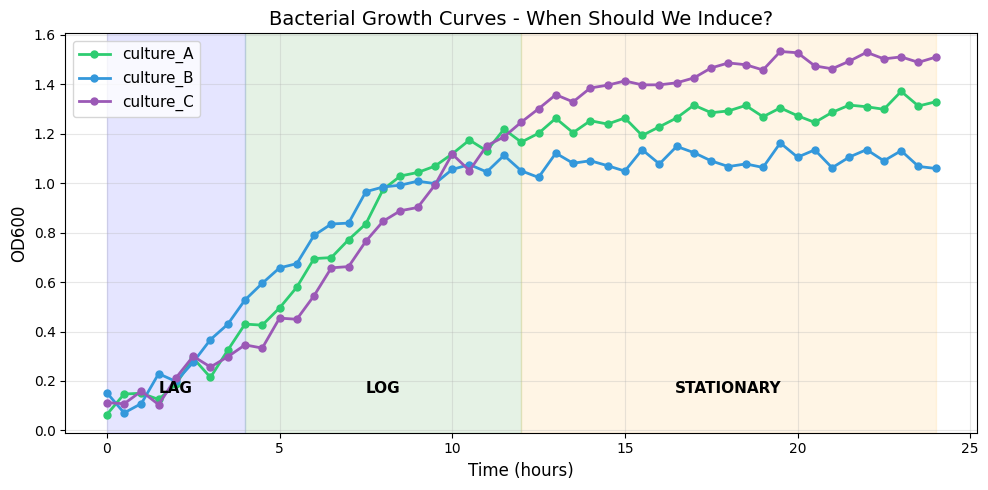


DISCUSSION QUESTION:
Looking at these curves:
  1. Which phase is each culture currently in?
  2. At what OD600 would you typically induce? (hint: 0.4-0.8)
  3. The three cultures grow at different rates - how would you
     determine the optimal induction TIME for each?


In [3]:
# Load the growth curve data
pr_df = load_plate_reader_data()

# Visualize it - this is what you'd see on the plate reader software
plt.figure(figsize=(10, 5))
colors = {'culture_A': '#2ecc71', 'culture_B': '#3498db', 'culture_C': '#9b59b6'}

for col in pr_df.columns[1:]:
    plt.plot(pr_df['time_hr'], pr_df[col], 'o-', markersize=5, 
             color=colors.get(col, 'gray'), label=col, linewidth=2)

plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('OD600', fontsize=12)
plt.title('Bacterial Growth Curves - When Should We Induce?', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add phase labels
plt.axvspan(0, 4, alpha=0.1, color='blue')
plt.axvspan(4, 12, alpha=0.1, color='green')
plt.axvspan(12, 24, alpha=0.1, color='orange')
plt.text(2, 0.15, 'LAG', fontsize=11, ha='center', fontweight='bold')
plt.text(8, 0.15, 'LOG', fontsize=11, ha='center', fontweight='bold')
plt.text(18, 0.15, 'STATIONARY', fontsize=11, ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DISCUSSION QUESTION:")
print("="*60)
print("Looking at these curves:")
print("  1. Which phase is each culture currently in?")
print("  2. At what OD600 would you typically induce? (hint: 0.4-0.8)")
print("  3. The three cultures grow at different rates - how would you")
print("     determine the optimal induction TIME for each?")

## Group Discussion

**What do we need to figure out?**

1. The **growth rate** of each culture (how fast are they dividing?)
2. The **mid-log point** - the inflection point where growth is fastest
3. What **time** to induce each culture

**The approach:**
- Growth curves follow a **logistic (S-shaped) pattern**
- The inflection point of a logistic curve = **mid-log phase**
- If we fit a logistic model, we can find this mathematically!

**The logistic growth model:**
```
OD(t) = OD_max / (1 + exp(-rate × (t - lag)))
```
Where `lag` is the inflection point (mid-log time)!

## Writing the Vibe Prompt

If you were asking Claude, ChatGPT, or Copilot to help, what would you say?

---

### Example Prompt:

> *I have bacterial growth curves (OD600 vs time in hours) for 3 cultures. I want to determine the optimal time to induce protein expression for each.*
>
> *Please:*
> 1. *Fit a logistic growth model to each curve*
> 2. *Extract the inflection point (mid-log time) for each*  
> 3. *Tell me the OD600 at that time*
> 4. *Show the fits overlaid on the data with the induction points marked*
>
> *The logistic model is: OD(t) = OD_max / (1 + exp(-rate × (t - lag)))*

---

**Key elements of a good vibe prompt:**
- Describe your **data** (growth curves, OD600, hours)
- State your **goal** (find optimal induction time)
- List the **steps** you need
- Specify the **output format** (table, plot)

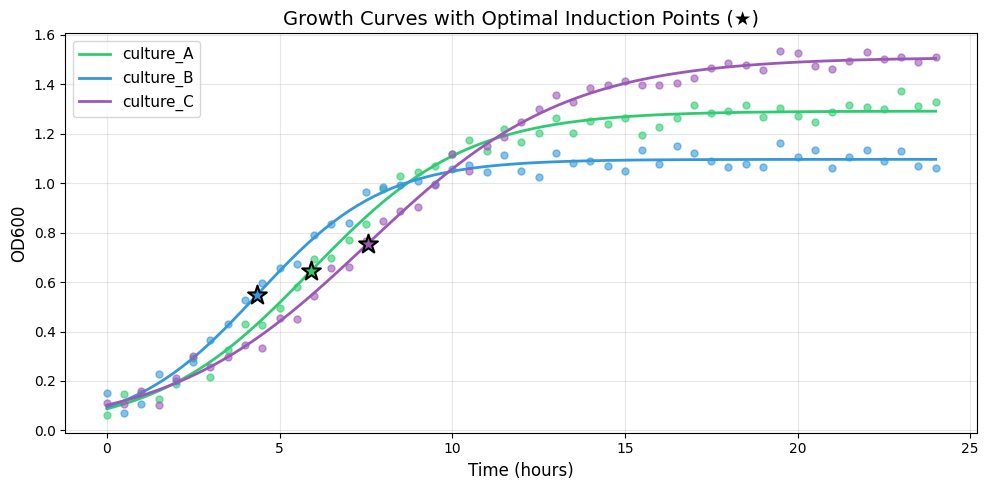


RECOMMENDED INDUCTION TIMES:
  Culture  Growth Rate  Optimal Induction Time (hr)  OD at Induction
culture_A        0.443                          5.9             0.65
culture_B        0.545                          4.3             0.55
culture_C        0.347                          7.6             0.75


In [4]:
# THE VIBE-CODED SOLUTION:
# (This is what an AI assistant might generate from our prompt)

time = pr_df['time_hr'].values
results = []

plt.figure(figsize=(10, 5))
colors = {'culture_A': '#2ecc71', 'culture_B': '#3498db', 'culture_C': '#9b59b6'}

for col in pr_df.columns[1:]:
    y = pr_df[col].values
    
    # Fit logistic growth model
    p0 = [y.max(), 0.4, 8]  # Initial guesses: [max_od, rate, lag]
    popt, _ = curve_fit(logistic_growth, time, y, p0=p0,
                        bounds=([0, 0.05, 0], [3, 2, 30]), maxfev=10000)
    max_od, rate, lag = popt
    
    # The lag parameter IS the inflection point (mid-log phase)
    optimal_time = lag
    optimal_od = logistic_growth(optimal_time, *popt)
    
    results.append({
        'Culture': col,
        'Growth Rate': round(rate, 3),
        'Optimal Induction Time (hr)': round(optimal_time, 1),
        'OD at Induction': round(optimal_od, 2)
    })
    
    # Plot data and fit
    color = colors.get(col, 'gray')
    plt.plot(time, y, 'o', markersize=5, color=color, alpha=0.6)
    t_fit = np.linspace(0, 24, 100)
    y_fit = logistic_growth(t_fit, *popt)
    plt.plot(t_fit, y_fit, '-', color=color, linewidth=2, label=f'{col}')
    
    # Mark the optimal induction point with a big star
    plt.scatter([optimal_time], [optimal_od], s=200, color=color, 
                marker='*', edgecolor='black', linewidth=1.5, zorder=5)

plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('OD600', fontsize=12)
plt.title('Growth Curves with Optimal Induction Points (★)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show results as a table
print("\n" + "="*60)
print("RECOMMENDED INDUCTION TIMES:")
print("="*60)
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

## Interpret the Results

**Check your understanding:**

1. Do the recommended induction times make sense visually? (Are the stars at the inflection points?)
2. Are the OD values at induction in the expected range (0.4-0.8)?
3. Which culture grows fastest? Which would you pick for a quick test expression?

**Real-world note:** 
- In practice, you might induce slightly *before* the calculated time to catch cells in early-log
- This gives you a **data-driven starting point** - always optimize empirically!

---

---

# Problem 2: "Is Our Drug Still Working on the Mutant?"

## The Scenario

You're studying a **GPCR (G protein-coupled receptor)** - a major drug target. You've made a point mutation (P415A) in a residue you think is important for drug binding.

You run a **cAMP assay**: cells expressing the receptor are treated with increasing concentrations of your drug (PCO371), and you measure the cAMP response.

**The question:** Did the mutation affect drug response?

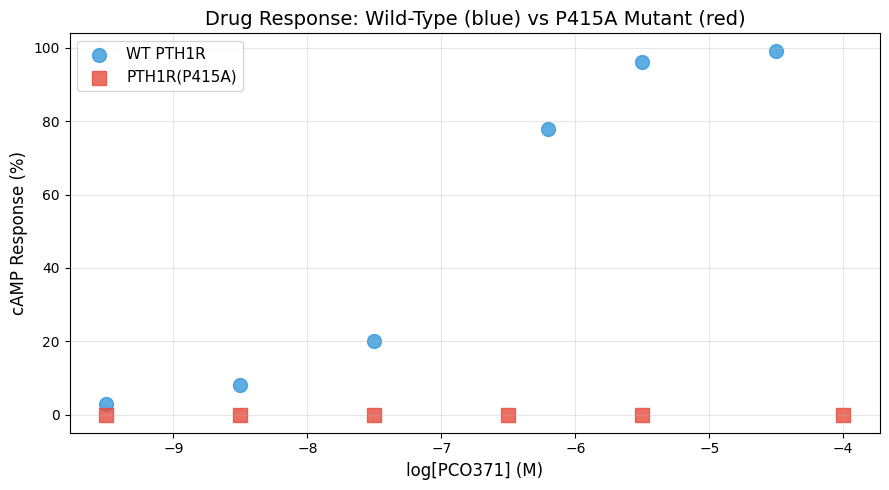


DISCUSSION QUESTION:
Looking at these data points:
  1. The mutant (red) responds less - but HOW MUCH less?
  2. Is it a change in POTENCY (EC50) or EFFICACY (max response)?
  3. How would you quantify this to put in a paper?


In [5]:
# Load the dose-response data
dr_df = load_dose_response_data()

# Filter to our comparison: WT vs P415A mutant
ligand = 'PCO371'
receptors = ['WT PTH1R', 'PTH1R(P415A)']
subset = dr_df[(dr_df['Ligand'] == ligand) & (dr_df['Receptor'].isin(receptors))]

# Plot the raw data
plt.figure(figsize=(9, 5))
for receptor in receptors:
    data = subset[subset['Receptor'] == receptor].sort_values('LogConcentration')
    color = '#3498db' if 'WT' in receptor else '#e74c3c'
    marker = 'o' if 'WT' in receptor else 's'
    plt.scatter(data['LogConcentration'], data['Response'], 
                s=100, label=receptor, color=color, marker=marker, alpha=0.8)

plt.xlabel('log[PCO371] (M)', fontsize=12)
plt.ylabel('cAMP Response (%)', fontsize=12)
plt.title('Drug Response: Wild-Type (blue) vs P415A Mutant (red)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DISCUSSION QUESTION:")
print("="*60)
print("Looking at these data points:")
print("  1. The mutant (red) responds less - but HOW MUCH less?")
print("  2. Is it a change in POTENCY (EC50) or EFFICACY (max response)?")
print("  3. How would you quantify this to put in a paper?")

## Group Discussion

**Key pharmacology concepts:**

| Parameter | What it measures | Biological meaning |
|-----------|-----------------|--------------------|
| **EC50** | Concentration at 50% response | Drug *potency* - how much drug you need |
| **Emax** | Maximum response achieved | Drug *efficacy* - how well it works at high doses |
| **Hill slope** | Steepness of curve | Cooperativity of binding |

**What could have changed?**
- EC50 shifted but Emax same → Mutation affects **binding affinity**
- Emax dropped but EC50 similar → Mutation affects **signaling/coupling**
- Both changed → **Complex effect**

**The 4-parameter logistic model:**
```
Response = Bottom + (Top - Bottom) / (1 + 10^((logEC50 - X) × Hill))
```

## Writing the Vibe Prompt

---

### Example Prompt:

> *I have dose-response data comparing wild-type and mutant receptor responses to a drug. I want to quantify the difference.*
>
> *Please:*
> 1. *Fit a 4-parameter logistic curve to each dataset*
> 2. *Extract EC50 (in nM) and Emax for each*
> 3. *Calculate: what % of WT Emax does the mutant achieve?*
> 4. *Calculate: fold-change in EC50*
> 5. *Show the fitted curves overlaid on the data*
>
> *The 4-parameter logistic: Y = Bottom + (Top-Bottom)/(1 + 10^((logEC50-X)×Hill))*

---

C:\Users\hidbe\AppData\Local\Temp\ipykernel_15896\4245351711.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(logistic_fn, x, y, p0=p0, maxfev=5000)


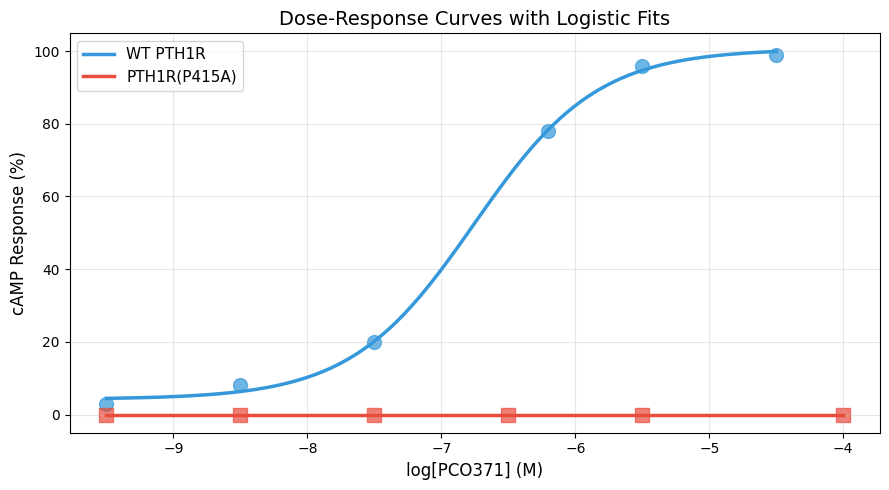


FITTED PARAMETERS:
    Receptor  Emax (%)  EC50 (nM)  Hill slope
    WT PTH1R     100.6      175.5        0.94
PTH1R(P415A)       0.0      100.0        1.00

ANALYSIS FOR YOUR PAPER:
  Emax: Mutant achieves 0% of WT maximum response
  EC50: Mutant has 0.6-fold shift in potency


In [6]:
# THE VIBE-CODED SOLUTION:

results = []
plt.figure(figsize=(9, 5))

for receptor in receptors:
    data = subset[subset['Receptor'] == receptor].sort_values('LogConcentration')
    x = data['LogConcentration'].values
    y = data['Response'].values
    
    # Fit the 4-parameter logistic
    p0 = [0, y.max(), -7, 1]  # Initial guesses
    popt, _ = curve_fit(logistic_fn, x, y, p0=p0, maxfev=5000)
    bottom, top, log_ec50, hill = popt
    
    # Convert EC50 to nM (x is in log[M])
    ec50_nM = 10**(log_ec50 + 9)
    
    results.append({
        'Receptor': receptor,
        'Emax (%)': round(top, 1),
        'EC50 (nM)': round(ec50_nM, 1),
        'Hill slope': round(hill, 2)
    })
    
    # Plot data and fit
    color = '#3498db' if 'WT' in receptor else '#e74c3c'
    marker = 'o' if 'WT' in receptor else 's'
    plt.scatter(x, y, s=100, color=color, marker=marker, alpha=0.7)
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = logistic_fn(x_fit, *popt)
    plt.plot(x_fit, y_fit, '-', color=color, linewidth=2.5, label=f'{receptor}')

plt.xlabel('log[PCO371] (M)', fontsize=12)
plt.ylabel('cAMP Response (%)', fontsize=12)
plt.title('Dose-Response Curves with Logistic Fits', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Results table
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("FITTED PARAMETERS:")
print("="*60)
print(results_df.to_string(index=False))

# Calculate the key comparisons
wt = results_df[results_df['Receptor'].str.contains('WT')].iloc[0]
mut = results_df[~results_df['Receptor'].str.contains('WT')].iloc[0]

print("\n" + "="*60)
print("ANALYSIS FOR YOUR PAPER:")
print("="*60)
print(f"  Emax: Mutant achieves {mut['Emax (%)']/wt['Emax (%)']*100:.0f}% of WT maximum response")
print(f"  EC50: Mutant has {mut['EC50 (nM)']/wt['EC50 (nM)']:.1f}-fold shift in potency")

## Interpret the Results

**What does this tell us biologically?**

Look at your results:
- If Emax is much lower → The mutant has **reduced efficacy** (can't fully activate)
- If EC50 is much higher → The mutant has **reduced potency** (needs more drug)

**For your paper/presentation:**
> "The P415A mutation reduced maximum response to X% of wild-type and shifted EC50 by Y-fold, suggesting that residue P415 is important for [binding/signaling/coupling]."

---

---

# Problem 3: "Which Sample Should We Crystallize?"

## The Scenario

You've purified 10 protein constructs and want to pick the best ones for crystallization trials. You run **FSEC (Fluorescence Size-Exclusion Chromatography)** on all samples.

**What makes a good crystallization candidate?**
- **Single sharp peak** = monodisperse (homogeneous)
- **No aggregates** = no early-eluting peaks
- **Consistent retention time** = expected size

The raw traces look messy due to baseline drift. How do we compare them fairly?

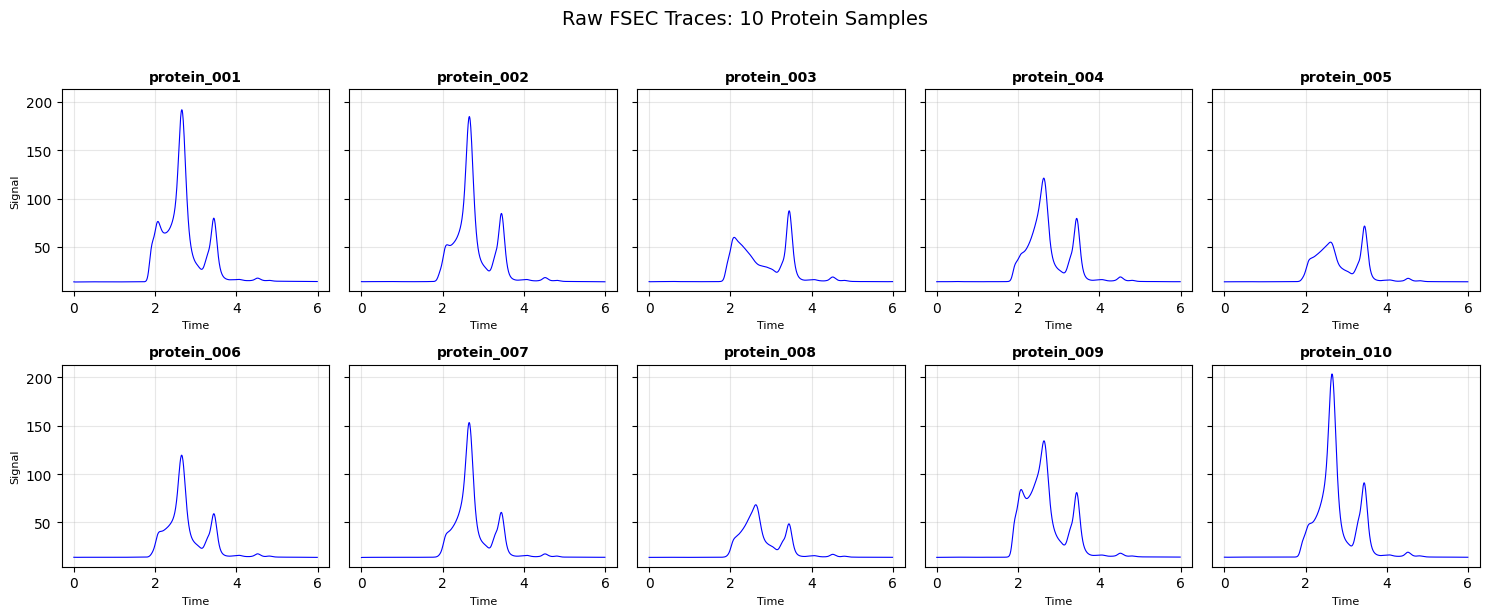


DISCUSSION QUESTION:
Looking at these raw traces:
  1. Can you easily compare the peak shapes?
  2. What problems do you see? (hint: baseline drift)
  3. Which protein do you chose?


In [8]:
# Load FSEC data
fsec_df = load_fsec_data()

# Show all 10 traces in a grid
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharey=True)
axes = axes.flatten()

for i, col in enumerate(fsec_df.columns[1:]):
    axes[i].plot(fsec_df['Timepoint'], fsec_df[col], 'b-', linewidth=0.8)
    axes[i].set_title(col, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Time', fontsize=8)
    if i % 5 == 0:
        axes[i].set_ylabel('Signal', fontsize=8)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Raw FSEC Traces: 10 Protein Samples', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DISCUSSION QUESTION:")
print("="*60)
print("Looking at these raw traces:")
print("  1. Can you easily compare the peak shapes?")
print("  2. What problems do you see? (hint: baseline drift)")
print("  3. Which protein do you chose?")

## Writing the Vibe Prompt

---

### Example Prompt:

> *I have FSEC (size-exclusion chromatography) traces for 10 protein samples. The traces have baseline drift and I need to compare them fairly.*
>
> *Please:*
> 1. *Correct the baseline drift in each trace*
> 2. *Normalize each trace to 0-1 scale so I can compare peak shapes*
> 3. *Detect peaks in each trace and count them*
> 4. *Rank the samples by "crystallization quality" (best peak shape, differentiation between peaks etc)*
> 5. *Show the corrected traces with peaks marked*

---

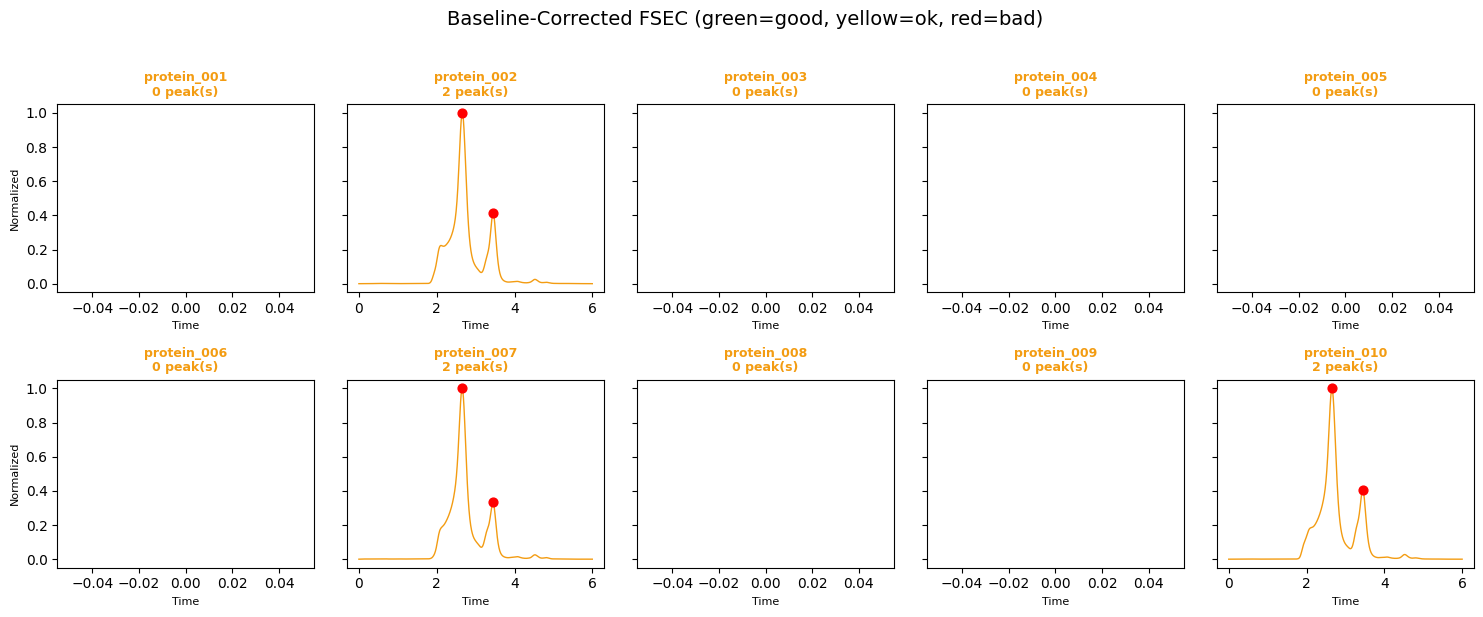


CRYSTALLIZATION CANDIDATES (ranked):
     Sample  Num Peaks  Quality Score
protein_002          2           0.25
protein_010          2           0.25
protein_007          2           0.25
protein_001          0           0.00
protein_003          0           0.00
protein_004          0           0.00
protein_006          0           0.00
protein_005          0           0.00
protein_008          0           0.00
protein_009          0           0.00

🏆 Top picks for crystallization: []


In [9]:
# THE VIBE-CODED SOLUTION:

results = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharey=True)
axes = axes.flatten()

for i, col in enumerate(fsec_df.columns[1:]):
    signal = fsec_df[col].values
    time = fsec_df['Timepoint'].values
    
    # Step 1: Baseline correction
    corrected, baseline = snip_baseline(signal, window_size=100)
    
    # Step 2: Normalize to 0-1
    normalized = (corrected - corrected.min()) / (corrected.max() - corrected.min() + 1e-8)
    
    # Step 3: Find peaks
    peaks, properties = find_peaks(normalized, prominence=0.1, width=5)
    num_peaks = len(peaks)
    
    # Step 4: Quality score (single sharp peak = best)
    if num_peaks > 0:
        main_peak_height = max(normalized[peaks])
        # Penalize multiple peaks heavily
        quality = main_peak_height / (num_peaks ** 2)
    else:
        quality = 0
    
    results.append({
        'Sample': col,
        'Num Peaks': num_peaks,
        'Quality Score': round(quality, 3)
    })
    
    # Plot corrected trace
    color = '#27ae60' if num_peaks == 1 else '#e74c3c' if num_peaks > 2 else '#f39c12'
    axes[i].plot(time, normalized, '-', color=color, linewidth=1)
    axes[i].scatter(time[peaks], normalized[peaks], c='red', s=40, zorder=5)
    axes[i].set_title(f"{col}\n{num_peaks} peak(s)", fontsize=9, 
                      color=color, fontweight='bold')
    axes[i].set_xlabel('Time', fontsize=8)
    if i % 5 == 0:
        axes[i].set_ylabel('Normalized', fontsize=8)

plt.suptitle('Baseline-Corrected FSEC (green=good, yellow=ok, red=bad)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Rank samples
results_df = pd.DataFrame(results).sort_values('Quality Score', ascending=False)
print("\n" + "="*60)
print("CRYSTALLIZATION CANDIDATES (ranked):")
print("="*60)
print(results_df.to_string(index=False))
print("\n🏆 Top picks for crystallization:", 
      list(results_df[results_df['Num Peaks'] == 1]['Sample'].values))

## Interpret the Results

**Check your understanding:**

1. Do the color-coded traces match your visual assessment?
2. Do samples with high quality scores look like good crystallization candidates?
3. Would you trust this ranking to decide which samples to set up first?

**Real-world note:**
- This automated analysis saves hours of manual inspection
- But always visually verify your top candidates!
- Peak width and symmetry also matter (could add to the scoring)

---

---

# Problem 4: "Can We Automate Crystal Screening?"

## The Scenario

You've set up a **crystallization screen** with 1,536 conditions. After a week, you need to check each drop and classify it. Manually, this takes **days**.

| Class | What it looks like | What to do |
|-------|-------------------|------------|
| **Clear** | Empty, transparent | Increase protein/precipitant |
| **Crystals** | Sharp edges, geometric | Optimize and harvest! |
| **Precipitate** | Cloudy, amorphous | Reduce protein/precipitant |
| **Other** | Phase separation, skin | Investigate |

**Question:** Can machine learning help?

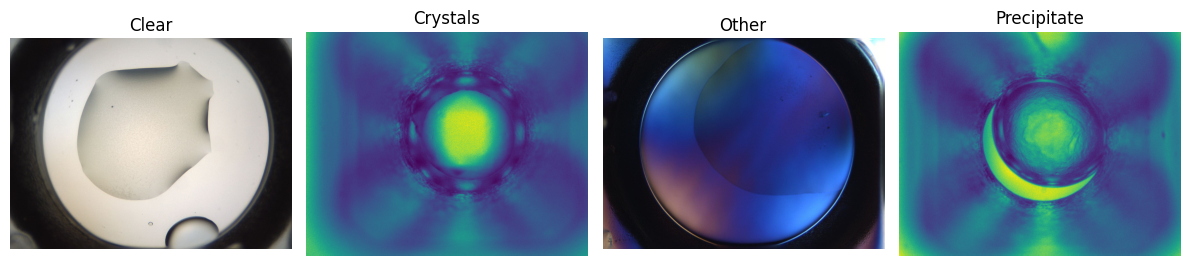


DISCUSSION QUESTION:
  1. What visual features distinguish crystals from precipitate?
  2. Could you write simple rules to classify these?
  3. What makes this hard for a computer?


In [10]:
# Preview example images from each class
try:
    preview_marco_samples()
    print("\n" + "="*60)
    print("DISCUSSION QUESTION:")
    print("="*60)
    print("  1. What visual features distinguish crystals from precipitate?")
    print("  2. Could you write simple rules to classify these?")
    print("  3. What makes this hard for a computer?")
except Exception as e:
    print("MARCO dataset images not available.")
    print("\nImagine images showing:")
    print("  - Clear: empty transparent drops")
    print("  - Crystals: sharp geometric edges")
    print("  - Precipitate: cloudy, fuzzy blobs")
    print("  - Other: weird phase separation patterns")

## The Approach: Transfer Learning

**Why not write rules?**
- "Sharp edges = crystal" sounds simple but fails on edge cases
- Too many exceptions to handle

**Modern approach: Transfer Learning**
1. Take a network pre-trained on millions of images (ResNet18)
2. Use it to extract "features" - it already knows about edges, textures, shapes
3. Train a simple classifier (logistic regression) on those features

**The vibe prompt would be:**

> *I have labeled crystallization images (Clear, Crystals, Precipitate, Other). I want to train a classifier using transfer learning - extract features from a pre-trained ResNet18 and train a logistic regression classifier on those features. Save the model so I can use it on new images.*

Loaded classifier for: ['Clear', 'Crystals', 'Other', 'Precipitate']


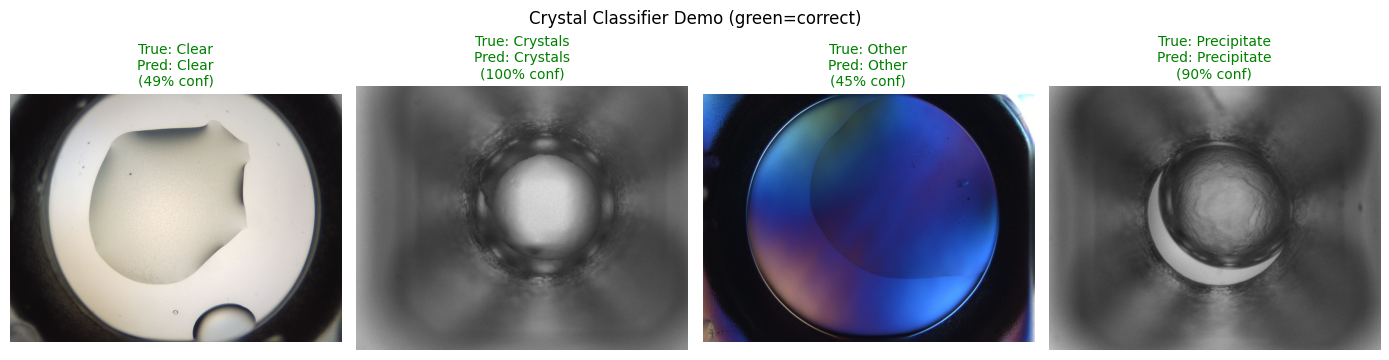

In [11]:
# DEMO: Load pre-trained classifier and run predictions
# (Training takes time - the full script is in session2_crystal_classifier.py)

import joblib
from pathlib import Path
from PIL import Image

model_path = Path('session2_crystal_classifier.pt')
data_root = Path('materials/session2/data/marco-protein-crystal-image-recognition/converted_train')

if not model_path.exists():
    print("Pre-trained model not available.")
    print("\nTo train one yourself (~5 min on CPU):")
    print("  python session2_crystal_classifier.py --limit 500")
elif not data_root.exists():
    print("MARCO dataset not available for demo.")
else:
    saved = joblib.load(model_path)
    clf = saved['model']
    classes = saved['classes']
    print(f"Loaded classifier for: {classes}")
    
    try:
        import torch
        import torch.nn as nn
        from torchvision import models, transforms
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        resnet.fc = nn.Identity()
        resnet.to(device).eval()
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        fig, axes = plt.subplots(1, 4, figsize=(14, 4))
        for ax, class_name in zip(axes, classes):
            class_dir = data_root / class_name
            if class_dir.exists():
                imgs = list(class_dir.glob('*.jpg'))[:1]
                if imgs:
                    img = Image.open(imgs[0]).convert('RGB')
                    ax.imshow(img)
                    
                    with torch.no_grad():
                        features = resnet(transform(img).unsqueeze(0).to(device)).cpu().numpy()
                    pred = classes[clf.predict(features)[0]]
                    conf = max(clf.predict_proba(features)[0]) * 100
                    
                    color = 'green' if pred == class_name else 'red'
                    ax.set_title(f"True: {class_name}\nPred: {pred}\n({conf:.0f}% conf)", 
                                color=color, fontsize=10)
            ax.axis('off')
        plt.suptitle('Crystal Classifier Demo (green=correct)', fontsize=12)
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("PyTorch not installed. Install with: pip install torch torchvision")

## Interpret the Results

**Key points:**
- ML classifiers are great for **first-pass screening** - find hits quickly
- But for final decisions (harvest this crystal?), **human expertise still matters**
- The classifier gives you confidence scores - low confidence = human review needed

**The workflow in practice:**
1. Run classifier on all 1,536 images
2. Sort by "Crystals" probability
3. Human reviews top candidates
4. Time saved: hours → minutes

---

---

# Problem 5: "Did the Mutation Change the Structure?" (Cautionary Tale)

## The Scenario

You've solved crystal structures of both wild-type and mutant proteins. Now you want to:
1. **Align** the structures to superimpose them
2. **Calculate RMSD** to quantify the difference

This is called **Procrustes analysis** - finding the best rotation to align two point sets.

**But there's a trap that has caught many computational biologists...**

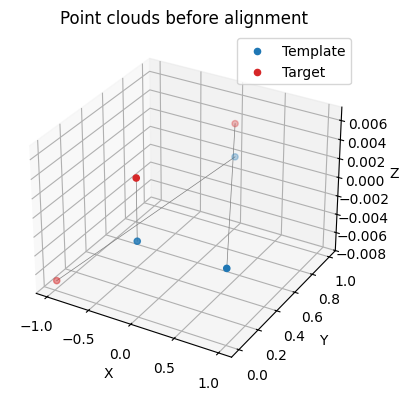

Blue = Template structure (wild-type)
Red = Target structure (mutant)

Goal: Find the rotation that aligns red to blue


In [12]:
# Generate example point sets (simplified protein coordinates)
A_pts, B_pts, true_rotation = generate_procrustes_example()
plot_procrustes_context(A_pts, B_pts)

print("Blue = Template structure (wild-type)")
print("Red = Target structure (mutant)")
print("\nGoal: Find the rotation that aligns red to blue")

## The Trap: Reflections vs. Rotations

The standard mathematical solution uses **SVD (Singular Value Decomposition)**.

**The problem:** SVD might give you a **reflection** instead of a **rotation**!

| | Rotation | Reflection |
|--|----------|------------|
| Determinant | det(R) = **+1** | det(R) = **-1** |
| Effect | Normal transform | **Mirror image!** |

**Why does this matter for proteins?**
- A reflected protein has L-amino acids becoming D-amino acids
- Helices wind the wrong way
- The structure is **chemically impossible**!

**True story:** AI assistants have generated naive Procrustes code that produces reflections. Always check!

## The Vibe Prompt (Safe Version)

---

### Example Prompt:

> *I want to align two protein structures using Procrustes analysis. IMPORTANT: I need a proper rotation, NOT a reflection!*
>
> *Please:*
> 1. *Center both point sets*
> 2. *Find the optimal rotation using SVD*
> 3. *CHECK if det(R) < 0 and FIX IT if so (flip the sign of the last singular vector)*
> 4. *Apply the rotation and calculate RMSD*
> 5. *Print the determinant before and after the fix so I can verify*

---

**Key insight:** Explicitly asking for the reflection check ensures safe code!

Initial determinant: 1.000
✓ Proper rotation (no fix needed)

Final RMSD: 0.0081 Å


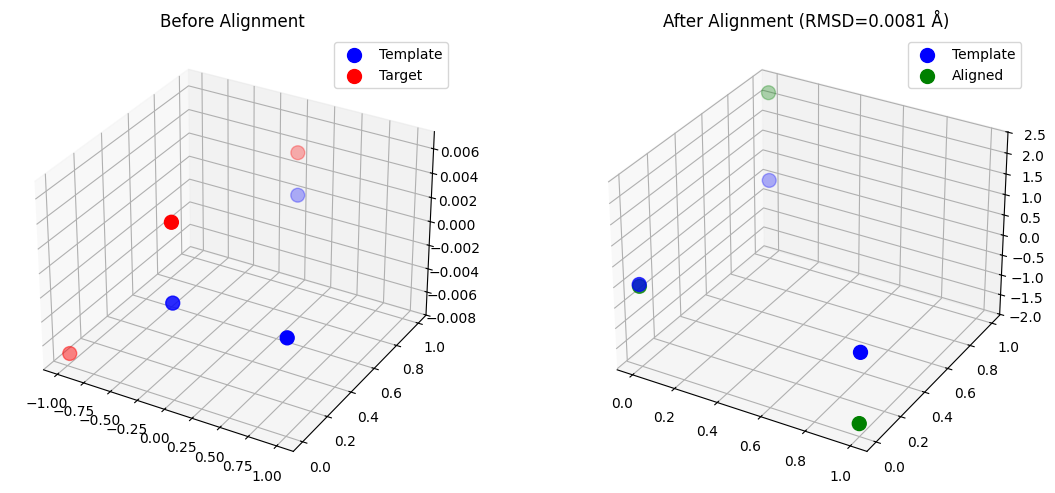

In [13]:
# THE VIBE-CODED SOLUTION (with reflection safety):

# Step 1: Center both point sets
A_centered = A_pts - A_pts.mean(axis=0)
B_centered = B_pts - B_pts.mean(axis=0)

# Step 2: Cross-covariance matrix
H = B_centered.T @ A_centered

# Step 3: SVD
U, S, Vt = np.linalg.svd(H)

# Step 4: Initial rotation
R_initial = U @ Vt
det = np.linalg.det(R_initial)
print(f"Initial determinant: {det:.3f}")

# Step 5: CHECK FOR REFLECTION!
if det < 0:
    print("⚠️  REFLECTION DETECTED! Fixing...")
    Vt[-1, :] *= -1  # Flip last row
    R_fixed = U @ Vt
    print(f"Fixed determinant: {np.linalg.det(R_fixed):.3f}")
else:
    print("✓ Proper rotation (no fix needed)")
    R_fixed = R_initial

# Step 6: Apply and calculate RMSD
B_aligned = (B_centered @ R_fixed) + A_pts.mean(axis=0)
rmsd = np.sqrt(np.mean(np.sum((A_pts - B_aligned)**2, axis=1)))
print(f"\nFinal RMSD: {rmsd:.4f} Å")

# Visualize
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*A_pts.T, c='blue', s=100, label='Template')
ax1.scatter(*B_pts.T, c='red', s=100, label='Target')
ax1.set_title('Before Alignment', fontsize=12)
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*A_pts.T, c='blue', s=100, label='Template')
ax2.scatter(*B_aligned.T, c='green', s=100, label='Aligned')
ax2.set_title(f'After Alignment (RMSD={rmsd:.4f} Å)', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.show()

## The Lesson

**Always validate computational results!**

AI assistants are powerful but can generate code with subtle bugs. For scientific applications:

1. **Understand what should happen** (rotation, not reflection)
2. **Include sanity checks** (determinant = +1)
3. **Visualize results** (does the alignment look right?)
4. **Ask for validation code** explicitly in your prompts

---

---

# Summary: The Vibe Coding Workflow

## What We Learned Today

| Problem | Question | Key Prompt Elements |
|---------|----------|--------------------|
| Growth curves | When to induce? | Fit logistic → find inflection point |
| Dose-response | Is the mutant affected? | Fit 4PL → extract EC50, Emax |
| FSEC | Which sample to crystallize? | Baseline correct → count peaks → rank |
| Crystal images | Can we automate screening? | Transfer learning → ResNet features → classify |
| Structure alignment | Did the mutation change shape? | SVD → CHECK determinant → apply rotation |

## Elements of a Good Vibe Prompt

1. **Describe your data** - format, size, what it represents
2. **State your goal** - what question are you answering?
3. **List the steps** - what transformations/analyses needed?
4. **Request validation** - sanity checks, visualizations
5. **Specify output** - table, plot, specific numbers?

## Key Takeaways

1. **Focus on the problem, not the code** - understanding > memorization
2. **AI is a tool, not a replacement** - you need to judge if results make sense
3. **Always visualize** - plots reveal problems that numbers hide
4. **Include sanity checks** - especially for scientific applications

---

## Next Steps

- Try writing vibe prompts for your own data analysis problems
- The reference solutions are in `session2_solutions.py`
- Practice judging AI-generated code: Does it do what you asked? Is it correct?